# Fritz Style Transfer

Train your own mobile-friendly style transfer model in minutes. Choose a style, train a model, and download a saved version in Keras, Core ML, or TensorFlow Mobile formats.

* To skip the training and get started quickly, head over to [Fritz](https://fritz.ai). 
* To see the final result, try our demo app, Heartbeat, available for both [iOS](bit.ly/heartbeat-ios) and [Android](bit.ly/heartbeat-android). 
* To dive into the soure code, head over to our [GitHub repository](https://github.com/fritzlabs/fritz-models/tree/master/style_transfer). If you find it useful, **star the repository**!

To get started training, **copy this notebook by hittig the "OPEN IN PLAYGROUND" button at the top of the page.**

In [0]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install keras==2.2.4
!pip install git+https://github.com/apple/coremltools.git@master

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-czg8oofe
  Running command git clone -q https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-czg8oofe
  Stored in directory: /tmp/pip-ephem-wheel-cache-jk4k0aa8/wheels/11/27/c8/4ed56de7b55f4f61244e2dc6ef3cdbaff2692527a2ce6502ba
Successfully built keras-contrib
  Cloning https://github.com/apple/coremltools.git (to revision master) to /tmp/pip-req-build-quh6eo7o
  Running command git clone -q https://github.com/apple/coremltools.git /tmp/pip-req-build-quh6eo7o
  Stored in directory: /tmp/pip-ephem-wheel-cache-94y_0zk7/wheels/cf/4b/ab/6283da44c6aee811fe45f7c0ac5c5afbe9ec7b43d1003da3de
Successfully built coremltools


In [0]:
import sys
import PIL.Image
import os
from IPython.utils import io

## Clone the Fritz Style Transfer Repository

In [0]:
# Install git lfs first so we can get download model checkpoints
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 16 not upgraded.
Need to get 5,730 kB of archives.
After this operation, 13.9 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.7.2 [5,730 kB]
Fetched 5,730 kB in 1s (6,519 kB/s)
Selecting previously unselec

In [0]:
!git clone https://github.com/fritzlabs/fritz-models.git

Cloning into 'fritz-models'...
remote: Enumerating objects: 94, done.
remote: Counting objects: 100% (94/94), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 896 (delta 28), reused 71 (delta 16), pack-reused 802
Receiving objects: 100% (896/896), 9.83 MiB | 11.96 MiB/s, done.
Resolving deltas: 100% (485/485), done.
Filtering content: 100% (13/13), 220.25 MiB | 45.96 MiB/s, done.


In [0]:
# Add the Fritz Style Transfer package to your python path
sys.path.append('/content/fritz-models/style_transfer/')

In [0]:
!mkdir fritz-models/style_transfer/data/

## Choose a style

Not all style images are equal. For the best results, pick images that:


1.   Have large geometric patterns on the scale of 10% - 33% of the images width
2.   Have bold, contrasting color palletes
3.   Have strong edges

If you're looking for inspiration, consider searching [Unslash](https://unspalsh.com) for [Flickr](https://www.flickr.com/search/) for terms like "abstract" or "geometric".

Make sure any images you use have an appropriate license.


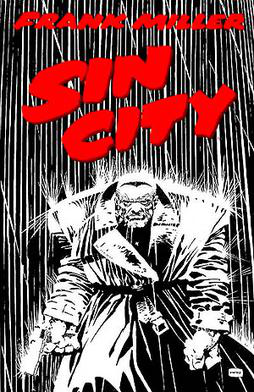

In [0]:
#@title Choose an image
#@markdown Enter the URL of the style image you want to use. The default is taking from here: https://flic.kr/p/8QaLwY
image_url = "https://upload.wikimedia.org/wikipedia/en/d/da/Sin_City_Hard_Goodbye.jpg" #@param {type:"string"}
"https://nerdophiles.files.wordpress.com/2013/05/goodbye-6.png?w=300&h=217"
"https://farm5.staticflickr.com/4147/5139595004_9d5ab31bfe_b_d.jpg"
"https://upload.wikimedia.org/wikipedia/en/d/da/Sin_City_Hard_Goodbye.jpg"
#@markdown Optionally add crop to create a better pattern. You may not need this
crop_image = False #@param {type:"boolean"}
if crop_image:
    crop_box = [250, 100, 750, 600] #@param {type:"raw"}


with io.capture_output(stderr=False) as captured:
    !cd fritz-models/style_transfer/data/ && wget -O style_image.jpg $image_url

style_image = image = PIL.Image.open('fritz-models/style_transfer/data/style_image.jpg')

if crop_image:
    style_image = style_image.crop(box=[250, 100, 750, 600])

style_image



## Download Training Data

We will use the 5000 images from the [COCO 2017 validation](http://cocodataset.org/#download) dataset for training.

In [0]:
training_data_url = "http://images.cocodataset.org/zips/val2017.zip"

!cd fritz-models/style_transfer/data/ && wget $training_data_url

print("Unzipping")
with io.capture_output(stderr=False):
    !unzip -o -d fritz-models/style_transfer/data/ fritz-models/style_transfer/data/val2017.zip

print(f"Finished Downloading data")

--2019-05-11 07:08:08--  http://images.cocodataset.org/zips/val2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.85.187
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.85.187|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 815585330 (778M) [application/zip]
Saving to: ‘val2017.zip’

val2017.zip         100%[===================>] 777.80M  35.6MB/s    in 22s     

2019-05-11 07:08:31 (34.6 MB/s) - ‘val2017.zip’ saved [815585330/815585330]

Unzipping
Finished Downloading data


## Convert Training Data to TFRecord

This typically takes a minute or two to run.

In [0]:
!python fritz-models/style_transfer/create_training_dataset.py \
--output fritz-models/style_transfer/data/training_images.tfrecord \
--image-dir fritz-models/style_transfer/data/val2017/


## Train the model

With a GPU attached, you should be able to use a batch size of 24 images. With a batch size of 24, 500 iteratorations should be fine to get us to 12,000 total steps. Because the style we've chosen is highly geometric with a large pattern, lets decrease the style weight by a factor of 10 to make the output look more like the original pictures.

Training on a GPU takes about 20 minutes. If you get memory errors, it probably means your runtime is trying to use the CPU or your batch size is too big. Training on TPUs is not yet supported.

In [0]:
!cd fritz-models/style_transfer/ && export PYTHONPATH=`pwd` && python style_transfer/train.py \
--training-image-dset data/training_images.tfrecord \
--style-images data/style_image.jpg \
--model-checkpoint data/my_style_025.h5 \
--image-size 256,256 \
--alpha 0.25 \
--num-iterations 500 \
--batch-size 24 \
--style-weight 0.00001 \
--fine-tune-checkpoint example/starry_night_256x256_025.h5


Using TensorFlow backend.
INFO:trainer:Creating dataset from: data/training_images.tfrecord
INFO:trainer:Loading style images:
data/style_image.jpg
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Colocations handled automatically by placer.
INFO:models:Loading weights from checkpoint: example/starry_night_256x256_025.h5
2019-05-11 07:29:59.378410: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 2300000000 Hz
2019-05-11 07:29:59.378713: I tensorflow/compiler/xla/service/service.cc:150] XLA service 0x49d3fa0 executing computations on platform Host. Devices:
2019-05-11 07:29:59.378774: I tensorflow/compiler/xla/service/service.cc:158]   StreamExecutor device (0): <undefined>, <undefined>
2019-05-11 07:29:59.529433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2019-05-11

## Stylize an image!

In [0]:
#@title Build Model
import style_transfer.models
import keras
from PIL import Image
from matplotlib import pyplot
import requests
from io import BytesIO
import numpy
from IPython.display import Markdown



def download_image(image_url):
    response = requests.get(image_url)
    return PIL.Image.open(BytesIO(response.content))


def run_prediction(model, image, image_size):
    image = image.resize(image_size)
    input_data = numpy.array(image)[None, :, :, :3] - 120.0
    output_data = model.predict(input_data)
    return PIL.Image.fromarray(output_data[0].astype('uint8'))


# Clear the keras session of the training we just did
keras.backend.clear_session()
# Load the model
image_size = (640, 640) #@param {type:"raw"}
model = style_transfer.models.StyleTransferNetwork.build(
    image_size,
    alpha=0.25, 
    checkpoint_file='/content/fritz-models/style_transfer/data/my_style_025.h5'
)

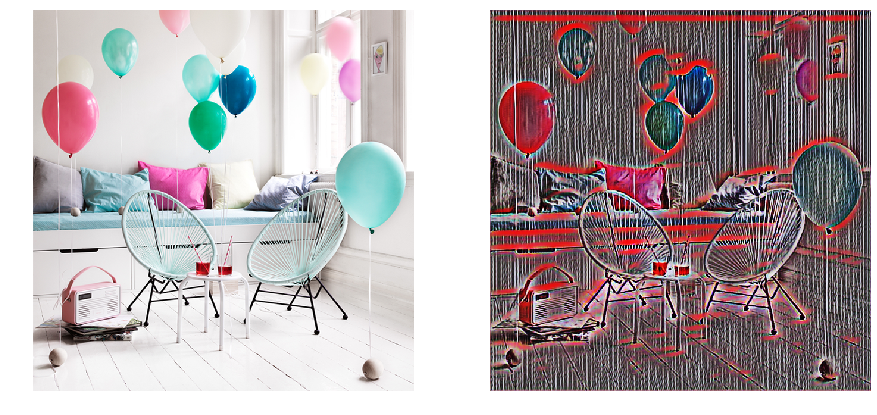

In [0]:
#@title Stylize an Image!
image_url = 'https://farm3.staticflickr.com/2907/14746369554_b783ba8d13_o_d.png' #@param {type:"string"}
image = download_image(image_url)
stylized_image = run_prediction(model, image, image_size)

fig, ax = pyplot.subplots(1,2);
fig.set_size_inches(15, 7)
ax[0].axis('off')
ax[1].axis('off')

ax[0].imshow(image);
ax[1].imshow(stylized_image);



In [0]:
# Download the model
# from google.colab import files
# files.download('/content/fritz-models/style_transfer/data/my_style_025.h5')